# Data Preparation

In this sectiono we load in and prepare the data for our machine learning.

https://github.com/albertbup/deep-belief-network

In [1]:
# !pip install scipy
# !pip install pandas
# !pip install scikit-learn

In [2]:
# !conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# # Anything above 2.10 is not supported on the GPU on Windows Native
# !pip install "tensorflow<2.11"


In [3]:
import os
import scipy.io as sio
import pandas as pd
from scipy.io import loadmat
import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

## Ingesting the data

The following data is from a Nasa dataset with n refferring to the iteration number of the dataset used. 
Temperature is in celcius
Voltage is in volts
Current is in Amps

In [4]:
n = 'B0005'
df = pd.read_csv('data_frames/' + 'NASA_cycle_dataset_' + n +'.csv',
                 parse_dates = ["datetime"]).drop(["Unnamed: 0"], axis = 1)
df.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,NaN
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,NaN
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,NaN
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,NaN
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,NaN


## Beginning Data engineering

In the Below cells we are attempting to fill in the missing values. A brief look at the dataset showed that each cycle potentially had a capacity for at least one of its rows. 

First we test that theory:

In [5]:
capacity_counts = pd.DataFrame(df.groupby('cycle')['capacity'].nunique())
zero_capacity_rows = capacity_counts[capacity_counts['capacity'] != 1]
# capacity_counts
zero_capacity_rows

,capacity
cycle,
169,0
170,0


The above cell shows that there is a singular battery capacity for each cycle except for 169 and 170.
For now we shall remove those two cycles as there is a large amount of deviation.

In [6]:
cap_std = df['capacity'].std()
cap_mean = df['capacity'].mean()

print(f"The standard deviation of capacity is {round(cap_std, 4)}.")
print(f"The average of capacity is {round(cap_mean, 4)}.")
print(f"This makes the standard deviation {round(cap_std/cap_mean*100,2)}% of the mean")

The standard deviation of capacity is 0.1824.
The average of capacity is 1.5603.
This makes the standard deviation 11.69% of the mean


In [7]:
df = df[df['cycle'] <  169]
caps = pd.DataFrame(df.groupby('cycle')['capacity'].max())
temp = df.merge(caps, on='cycle', how='left').ffill()
temp = temp.drop(["capacity_x"], axis = 1).rename(columns = {"capacity_y" : "capacity"})
df = temp
temp.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,1.856487
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,1.856487
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,1.856487
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,1.856487
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,1.856487


In [8]:
df['ambient_temperature'].nunique()

1

# Machine Learning (DBN)

Now we begin to build our Deep Belief Network

In [30]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from tensorflow import keras
import warnings

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
prep_df = df.drop(['datetime', 'ambient_temperature'], axis = 1)
train_dataset = prep_df.sample(frac=0.8, random_state = 0)
test_dataset = prep_df.drop(train_dataset.index)

In [13]:
prep_df.shape

(587849, 8)

In [14]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cycle,470279.0,95.409219,42.773598,1.000000,60.000000,96.000000,132.000000,168.000000
voltage_measured,470279.0,4.103417,0.213988,2.471315,4.087904,4.205138,4.205908,8.393141
current_measured,470279.0,0.368345,0.909263,-4.479660,0.039531,0.171773,1.262020,1.530376
temperature_measured,470279.0,26.375203,2.778615,23.214802,24.489668,25.483638,27.353169,41.450232
current,470279.0,0.635250,0.737908,-4.468000,0.057000,0.261000,1.498000,1.998400
voltage,470279.0,4.021478,1.213135,0.000000,4.240000,4.305000,4.656000,5.002000
time,470279.0,4763.490005,3149.187573,0.000000,1925.390000,4464.735000,7504.617000,10807.328000
capacity,470279.0,1.531792,0.171983,1.287453,1.370513,1.511898,1.694580,1.856487


## Normalisation

Here we will normalise the values to give equal weight to each feature

In [15]:
# Test data is *not* used when calculating the mean and std.
mean = train_dataset.mean(axis=0)
std = train_dataset.std(axis=0)
train_dataset = (train_dataset - mean) / std
test_dataset = (test_dataset - mean) / std

train_dataset.head()  # First training sample, normalized

,cycle,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
489563,1.135999,-0.143625,1.256087,0.209200,1.171893,0.656582,-1.210051,-1.150031
383688,0.528148,0.459574,-0.405123,-0.703511,-0.860880,-3.312475,1.750762,-0.693171
580550,1.673714,0.477536,-0.315329,-0.783674,-0.752465,0.197441,0.651887,-1.295344
110450,-1.038239,0.484418,-0.371263,-0.158716,-0.818869,0.180130,1.413676,1.309582
354820,0.364495,0.485901,0.844907,1.435609,0.670476,0.621137,-0.755598,-0.541457


In [16]:
# These are the features
train_features = train_dataset.copy()
test_features = test_dataset.copy()
print(train_features.iloc[0])
# These contain the target variables
train_labels = train_features.pop('capacity')
test_labels = test_features.pop('capacity')
print('--------------------------')
print(train_features.iloc[0])

cycle                   1.135999
voltage_measured       -0.143625
current_measured        1.256087
temperature_measured    0.209200
current                 1.171893
voltage                 0.656582
time                   -1.210051
capacity               -1.150031
Name: 489563, dtype: float64
--------------------------
cycle                   1.135999
voltage_measured       -0.143625
current_measured        1.256087
temperature_measured    0.209200
current                 1.171893
voltage                 0.656582
time                   -1.210051
Name: 489563, dtype: float64


In [17]:
train_dataset.head()

,cycle,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
489563,1.135999,-0.143625,1.256087,0.209200,1.171893,0.656582,-1.210051,-1.150031
383688,0.528148,0.459574,-0.405123,-0.703511,-0.860880,-3.312475,1.750762,-0.693171
580550,1.673714,0.477536,-0.315329,-0.783674,-0.752465,0.197441,0.651887,-1.295344
110450,-1.038239,0.484418,-0.371263,-0.158716,-0.818869,0.180130,1.413676,1.309582
354820,0.364495,0.485901,0.844907,1.435609,0.670476,0.621137,-0.755598,-0.541457


In [18]:
num_rows = train_features.shape[1]
num_rows

7

## Regression with DBN

In [19]:
def build_and_compile_model():
    # Define the model architecture
    model = keras.models.Sequential()

    # Input layer
    model.add(Dense(64, input_dim=num_rows, activation='relu'))

    # Hidden layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))

    # Output layer - since we're doing regression, we have a single output node with no activation function
    model.add(Dense(1))

    # Compile the model - using Mean Squared Error (MSE) as the loss function for regression
    model.compile(optimizer=keras.optimizers.Adam(), loss='mean_squared_error', 
                  metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

def plot_loss(history, title):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Capacity]')
    plt.title(title)
    plt.legend()
    plt.grid(True)

In [20]:
dbn_model = build_and_compile_model()
dbn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 25,473
Trainable params: 25,473
Non-trainable params: 0
_________________________________________________________________


In [21]:
epochs = 30
checkpoint_filepath = os.path.join('checkpoints', 'DBN{epoch:02d}-{val_loss:.4f}.h5')
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='mean_squared_error',
    mode='min',
    save_best_only=True)

if 'history' not in locals():
    print('New History array has been created')
    history =  []

New History array has been created


In [22]:
%%time
history.append(dbn_model.fit(
    train_features,
    train_labels,
    validation_split = 0.2,
    epochs = epochs,
    callbacks = model_checkpoint_callback))

Epoch 1/30
11757/11757 [==============================] - 63s 5ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0532 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0472
Epoch 2/30
11757/11757 [==============================] - 61s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0384 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0369
Epoch 3/30
11757/11757 [==============================] - 59s 5ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0337 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0343
Epoch 4/30
11757/11757 [==============================] - 59s 5ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0315 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0282
Epoch 5/30
11757/11757 [==============================] - 60s 5ms/step - los

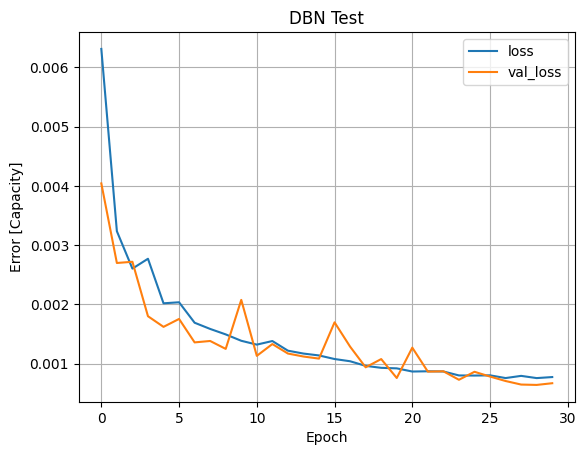

In [23]:
plot_loss(history[-1], "DBN Test")

In [24]:
model_path = os.path.join('models', 'DBN_03.keras')

In [25]:
dbn_model.save(model_path)

### Performance

In [26]:
dbn_model = keras.models.load_model(model_path)

### Make Predictions

In [27]:
test_predictions = dbn_model.predict(test_features).flatten()

3675/3675 [==============================] - 5s 1ms/step


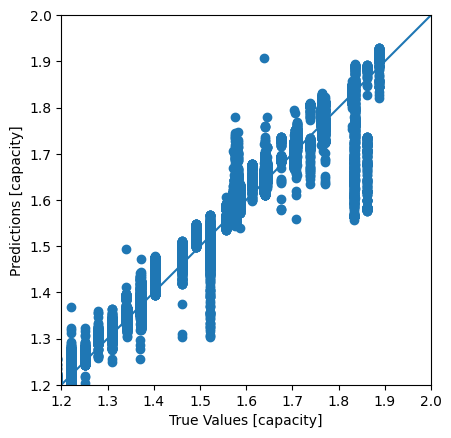

In [28]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [capacity]')
plt.ylabel('Predictions [capacity]')
lims = [1.2, 2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

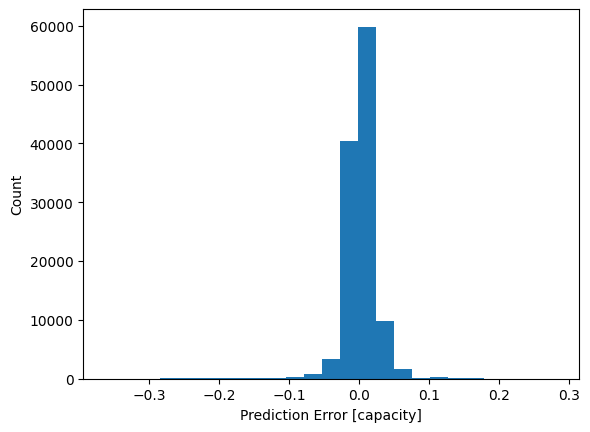

In [29]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [capacity]')
_ = plt.ylabel('Count')

In [31]:
# Calculate metrics
mse = mean_squared_error(test_labels, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_labels, test_predictions)
r2 = r2_score(test_labels, test_predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')

MSE: 0.0006616374990073729
RMSE: 0.025722315195319666
MAE: 0.014658870390223304
R2 Score: 0.9993382360759323
